# Import packages

In [1]:
# Suppress warnings
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
from pprint import pprint

import earthaccess
import xarray as xr

## Authenticate to NASA Earthdata

In [2]:
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

## Get a vector of urls to our nc files

In [12]:
short_name = 'MUR-JPL-L4-GLOB-v4.1'
version = "4.1"
date_start = "2021-06-01"
date_end = "2021-06-30"
date_range = (date_start, date_end)

min_lon = -26
max_lon = -15
min_lat = 10
max_lat = 18

# min lon, min lat, max lon, max lat
bbox = (min_lon, min_lat, max_lon, max_lat)  

results = earthaccess.search_data(
    short_name = short_name,
    version = version,
    cloud_hosted = True,
    temporal = date_range,
    bounding_box = bbox,
)
len(results)

31

In [13]:
results[0]

Collection: {'Version': '4.1', 'ShortName': 'MUR-JPL-L4-GLOB-v4.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180, 'NorthBoundingCoordinate': 90}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2021-06-01T21:00:00.000Z', 'BeginningDateTime': '2021-05-31T21:00:00.000Z'}}
Size(MB): 707.9639902114868
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc']

## Crop and plot one NetCDF file

In [14]:
fileset = earthaccess.open(results[0:1])
ds = xr.open_dataset(fileset[0])

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
ds

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2021-06-01T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Note that `xarray` works with "lazy" computation whenever possible. In this case, the metadata are loaded into JupyterHub memory, but the data arrays and their values are not — until there is a need for them.

Let's print out all the variable names.

In [16]:
for v in ds.variables:
    print(v)

time
lat
lon
analysed_sst
analysis_error
mask
sea_ice_fraction
dt_1km_data
sst_anomaly


Of the variables listed above, we are interested in `analysed_sst`.

In [17]:
ds.variables['analysed_sst'].attrs

{'long_name': 'analysed sea surface temperature',
 'standard_name': 'sea_surface_foundation_temperature',
 'units': 'kelvin',
 'valid_min': np.int16(-32767),
 'valid_max': np.int16(32767),
 'comment': '"Final" version using Multi-Resolution Variational Analysis (MRVA) method for interpolation',
 'source': 'MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, AVHRRMTB_G-NAVO, iQUAM-NOAA/NESDIS, Ice_Conc-OSISAF'}

### Subsetting

In addition to directly accessing the files archived and distributed by each of the NASA DAACs, many datasets also support services that allow us to customize the data via subsetting, reformatting, reprojection/regridding, and file aggregation. What does subsetting mean? To **subset** means to extract only the portions of a dataset that are needed for a given purpose. 

In [18]:
# Display the full dataset's metadata
ds

<xarray.Dataset> Size: 29GB
Dimensions:           (time: 1, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 8B 2021-06-01T09:00:00
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 5GB ...
    analysis_error    (time, lat, lon) float64 5GB ...
    mask              (time, lat, lon) float32 3GB ...
    sea_ice_fraction  (time, lat, lon) float64 5GB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 5GB ...
    sst_anomaly       (time, lat, lon) float64 5GB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Now we will prepare a subset. We're using essentially the same spatial bounds as above; however, as opposed to the `earthaccess` inputs above, here we must provide inputs in the formats expected by `xarray`. Instead of a single, four-element, bounding box, we use Python `slice` objects, which are defined by starting and ending numbers.

In [19]:
ds_subset = ds.sel(time=date_start, lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon)) 
ds_subset

<xarray.Dataset> Size: 39MB
Dimensions:           (time: 1, lat: 801, lon: 1101)
Coordinates:
  * time              (time) datetime64[ns] 8B 2021-06-01T09:00:00
  * lat               (lat) float32 3kB 10.0 10.01 10.02 ... 17.98 17.99 18.0
  * lon               (lon) float32 4kB -26.0 -25.99 -25.98 ... -15.01 -15.0
Data variables:
    analysed_sst      (time, lat, lon) float64 7MB ...
    analysis_error    (time, lat, lon) float64 7MB ...
    mask              (time, lat, lon) float32 4MB ...
    sea_ice_fraction  (time, lat, lon) float64 7MB ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] 7MB ...
    sst_anomaly       (time, lat, lon) float64 7MB ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

### Plotting

We will first plot using the methods built-in to the `xarray` package.

Note that, as opposed to the "lazy" loading of metadata previously, this will now perform "eager" computation, pulling the required data chunks.

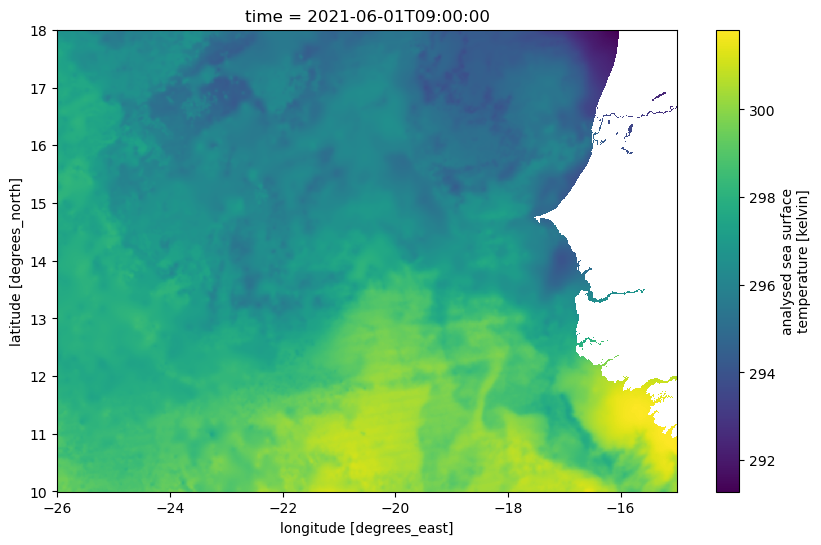

In [20]:
ds_subset['analysed_sst'].plot(figsize=(10,6), x='lon', y='lat');

## Create a data cube by combining multiple netCDF files

When we open multiple files, we use `open_mfdataset()`. Once again, we are doing lazy loading. Note this method works best if you are in the same Amazon Web Services (AWS) region as the data (us-west-2) and can use S3 connection. For the EDM workshop, we are on an Azure JupyterHub and are using https connection so this is much much slower. If we had spun up this JupyterHub on AWS us-west-2 where the NASA data are hosted, we could load a whole year of data instantly. We will load just a few days so it doesn't take so long.

In [21]:
fileset = earthaccess.open(results[0:6])


QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

In [26]:
fileset

<File-like object S3FileSystem, podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20210606090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc>

In [23]:
len(fileset)

6

In [28]:
ds = xr.open_mfdataset(fileset[0:5])
ds

<xarray.Dataset> Size: 143GB
Dimensions:           (time: 5, lat: 17999, lon: 36000)
Coordinates:
  * time              (time) datetime64[ns] 40B 2021-06-01T09:00:00 ... 2021-...
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 13GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 26GB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 26GB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [29]:
ds_subset = ds.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon)) 
ds_subset

<xarray.Dataset> Size: 194MB
Dimensions:           (time: 5, lat: 801, lon: 1101)
Coordinates:
  * time              (time) datetime64[ns] 40B 2021-06-01T09:00:00 ... 2021-...
  * lat               (lat) float32 3kB 10.0 10.01 10.02 ... 17.98 17.99 18.0
  * lon               (lon) float32 4kB -26.0 -25.99 -25.98 ... -15.01 -15.0
Data variables:
    analysed_sst      (time, lat, lon) float64 35MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 35MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
    mask              (time, lat, lon) float32 18MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 35MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 35MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 35MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

We can subset a slice of days also.

In [32]:
ds_subset_time = ds_subset.sel(time=slice(date_start, "2021-06-04"))
ds_subset_time

<xarray.Dataset> Size: 155MB
Dimensions:           (time: 4, lat: 801, lon: 1101)
Coordinates:
  * time              (time) datetime64[ns] 32B 2021-06-01T09:00:00 ... 2021-...
  * lat               (lat) float32 3kB 10.0 10.01 10.02 ... 17.98 17.99 18.0
  * lon               (lon) float32 4kB -26.0 -25.99 -25.98 ... -15.01 -15.0
Data variables:
    analysed_sst      (time, lat, lon) float64 28MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 28MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
    mask              (time, lat, lon) float32 14MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 28MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] 28MB dask.array<chunksize=(1, 130, 1101), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float64 28MB dask.array<chunksize=(1, 231, 977), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

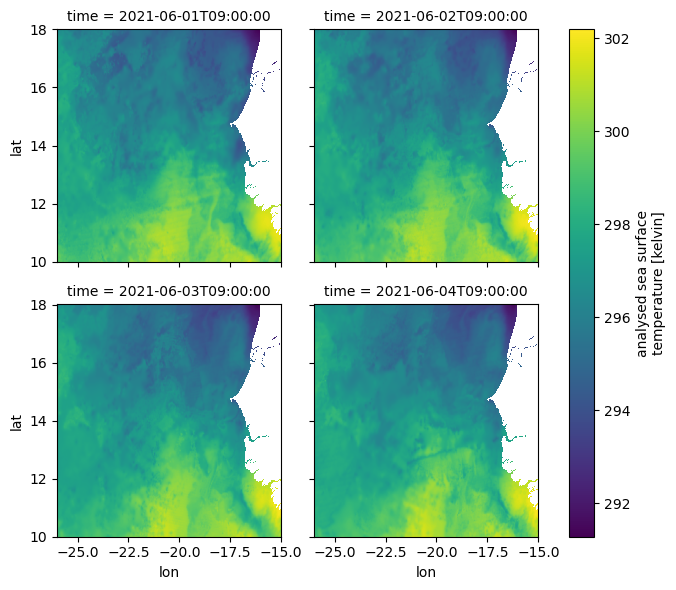

In [33]:
ds_subset_time['analysed_sst'].plot(x='lon', y='lat', col="time", col_wrap=2);